In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from math import gcd

In [2]:
"""
global variables

theta dir : num//4 pixels
phi dir : num pixels
2*pi/num per pixel
"""

PI = 3.14159265358979
wave_length = 1.0
k = 2*PI / wave_length
n_ = 120*PI
num = 64
r = 10 * wave_length
EPS = 1e-3

In [3]:
class Surface():
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny
        self.dir = np.zeros((num//4, num))
    
    """------------------  from here call after calling get_dir ------------------------"""
    
    def rotate2origin(self):
        i, j = np.unravel_index(np.argmax(self.dir, axis=None), self.dir.shape)
        dir_ = np.roll(self.dir, -j, axis=1)
        dir_ = np.roll(dir_, -i, axis=0)
        return dir_
    
    def get_maxdir(self):
        return np.max(self.dir)
    
    def get_hpbw(self):
        i, j = np.unravel_index(np.argmax(self.dir, axis=None), self.dir.shape)
        dmax = np.max(self.dir)
        hd = dmax - 3
        dir_ = np.abs(self.dir - hd)
        ti_lo = np.argmin(dir_[:,:j])
        ti_hi = np.argmin(dir_[:,j:-1])
        pi_lo = np.argmin(dir_[:i,:])
        pi_hi = np.argmin(dir_[i:-1,:])
        return (abs(ti_lo - ti_hi)*2*2*PI/num, abs(pi_lo-pi_hi)*2*2*PI/num)
    
    def plot_dir(self):
        d = self.dir
        theta = np.linspace(0, PI/2, num//4)
        phi = np.linspace(0, PI*2, num)
        phi_, theta_ = np.meshgrid(phi, theta)
        x = d * np.vstack(np.sin(theta_)) * np.cos(phi_)
        y = d * np.vstack(np.sin(theta_)) * np.sin(phi_)
        z = d * np.vstack(np.cos(theta_))
        
        dmax = np.max(d)
        i, j = np.unravel_index(np.argmax(d, axis=None), d.shape)
        #print(dmax)
        #print(i)
        #print(j)
        
        ax = plt.axes(projection='3d')
        ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
        ax.set_title('surface');
        ax.set_xlim([-35, 35])
        ax.set_ylim([-35, 35])
        ax.set_zlim(bottom = 0.0)

In [4]:
"""
metasurface with unit cells

nx, ny : number of cells in x, y direction
theta0, phi0 : steering angle in 3d coordinates
c : unitcell size

assume uniform E field for each unit cell surface
assume beta_x = k*c*sin(theta0)*cos(phi0) & beta_y = k*c*sin(theta0)*sin(phi0)

"""

class MetaSurfaceArray(Surface):
    def __init__(self, nx, ny, c):
        super(MetaSurfaceArray, self).__init__(nx, ny)
        self.c = c
        
    def get_array_factor(self, theta0, phi0):
        array_factor = np.zeros((num//4, num), dtype=np.complex128)
        xid = np.arange(0, self.nx, 1)
        yid = np.arange(0, self.ny, 1)
        px = np.sin(theta0)*np.cos(phi0)
        py = np.sin(theta0)*np.sin(phi0)
        
        #row : theta, col : phi
        for i in range(num//4):
            for j in range(num):
                theta = 2*PI/num*i
                phi = 2*PI/num*j
                x_expon = np.exp(1j*k*self.c*(np.sin(theta)*np.cos(phi) - px)*xid)
                y_expon = np.exp(1j*k*self.c*(np.sin(theta)*np.sin(phi) - py)*yid)
                array_factor[i, j] = np.sum(np.vstack(x_expon) * y_expon)
        self.array_factor = array_factor
        return array_factor
    
    def get_dir(self, theta0, phi0):
        theta = np.linspace(0, PI/2, num//4)
        sin_theta = np.vstack(np.sin(theta))
        
        array_factor = self.get_array_factor(theta0, phi0)
        u = np.real(array_factor*np.conj(array_factor))
        pr = 1/(4*PI)*np.sum(u*sin_theta*(4*PI*PI/(num**2))) 
        self.dir = 10*np.log10(u/pr)
        self.dir[self.dir<0] = 0

In [5]:
"""
metasurface with continuous E field distribution

nx, ny : number of pixels in x, y direction
dx : size of pixel
"""

class MetaSurfaceAperture(Surface):
    def __init__(self, nx, ny, dx):
        super(MetaSurfaceAperture, self).__init__(nx, ny)
        self.dx = dx
    
    def set_uniform_e_field(self, theta0, phi0):
        self.ex = np.ones((self.nx, self.ny))
        self.ey = np.zeros((self.nx, self.ny))
        self.hx = np.zeros((self.nx, self.ny))
        self.hy = np.zeros((self.nx, self.ny))
        
        self.set_phase(theta0, phi0)
    
    def set_random_e_field(self, theta0, phi0):
        self.ex = np.random.randn(self.nx, self.ny)
        self.ey = np.zeros((self.nx, self.ny))
        self.hx = np.zeros((self.nx, self.ny))
        self.hy = np.zeros((self.nx, self.ny))
        
        self.set_phase(theta0, phi0)
    
    def set_phase(self, theta0, phi0):
        px = np.sin(theta0)*np.cos(phi0)
        py = np.sin(theta0)*np.sin(phi0)
        xid = np.arange(0, self.nx, 1)
        yid = np.arange(0, self.ny, 1)
        x_expon = np.exp(-1j*k*self.dx*px*xid)
        y_expon = np.exp(-1j*k*self.dx*py*yid)
        self.ex = self.ex*(np.vstack(x_expon)*y_expon)
    
    def equivalence_theorem(self):
        mx = self.ey
        my = -self.ex
        jx = -self.hy
        jy = self.hx
        return (mx, my, jx, jy)

    def get_far_field(self):
        mx, my, jx, jy = self.equivalence_theorem()
        n_phi   = np.zeros((num//4, num), dtype=np.complex128)
        n_theta = np.zeros((num//4, num), dtype=np.complex128)
        l_phi   = np.zeros((num//4, num), dtype=np.complex128)
        l_theta = np.zeros((num//4, num), dtype=np.complex128)
        
        x = np.arange(0, self.dx*self.nx, self.dx)
        y = np.arange(0, self.dx*self.ny, self.dx)
        
        for i in range(num//4):
            for j in range(num):
                theta = 2*PI/num*i
                phi = 2*PI/num*j
                r_cos_ = np.vstack(x)*np.sin(theta)*np.cos(phi) + y*np.sin(theta)*np.sin(phi)
                exp = np.exp(1j*k*r_cos_)*self.dx*self.dx
                n_theta[i,j] = np.sum((jx*np.cos(theta)*np.cos(phi) + jy*np.cos(theta)*np.sin(phi))*exp)
                l_theta[i,j] = np.sum((mx*np.cos(theta)*np.cos(phi) + my*np.cos(theta)*np.sin(phi))*exp)
                n_phi[i,j] = np.sum((-jx*np.sin(phi) + jy*np.cos(phi))*exp)
                l_phi[i,j] = np.sum((-mx*np.sin(phi) + my*np.cos(phi))*exp)
        return (l_phi + n_theta*n_, -l_theta + n_phi*n_)
    
    def get_dir(self):
        theta = np.linspace(0, PI/2, num//4)
        sin_theta = np.vstack(np.sin(theta))
        
        e_theta, e_phi = self.get_far_field()
        u = np.real(e_theta*np.conj(e_theta) + e_phi*np.conj(e_phi))
        pr = 1/(4*PI)*np.sum(u*sin_theta*(4*PI*PI/(num**2))) 
        self.dir = 10*np.log10(u/pr)
        self.dir[self.dir<0] = 0

### given theta0, phi0, dmax, theta_h, phi_h 
### find nx & ny that fits best

In [9]:
"""
given : theta0, phi0, dmax, theta_h, phi_h, c(unit cell size)
return : nx, ny that produces beam that fits best

time complexity O(nx log(ny) * num^2 * nx * ny)
"""

def find_metasurface(input):
    theta0 = input[0]
    phi0 = input[1]
    dmax = input[2]
    theta_h = input[3]
    phi_h = input[4]
    c = input[5]
    
    nx_cand = np.arange(2, 21, 1)
    min_error = 1e9
    nx_rec = 0
    ny_rec = 0
    
    for nx_ in nx_cand: 
        lo = 2
        hi = 21
        ny_ = 2
        
        #binary search ny_ for fixed nx_
        while lo <= hi:
            mid = (lo + hi)//2
            tmp = MetaSurfaceArray(nx_, mid, c)
            tmp.get_dir(theta0, phi0)
            if tmp.get_maxdir() < dmax and abs(dmax-tmp.get_maxdir())>EPS:
                lo = mid + 1
            elif tmp.get_maxdir() > dmax and abs(dmax-tmp.get_maxdir())>EPS:
                hi = mid - 1
                ny_ = mid
            else:
                ny_ = mid
                break
        
        cand = MetaSurfaceArray(nx_, ny_, c)
        cand.get_dir(theta0, phi0)
        
        theta_h_, phi_h_ = cand.get_hpbw()
        error = abs((theta_h - theta_h_)/(theta_h+EPS)) + abs((phi_h - phi_h_)/(phi_h+EPS))
        #print(nx_, ny_, error)
        
        if error < min_error:
            min_error = error
            nx_rec = nx_
            ny_rec = ny_
            
    return (nx_rec, ny_rec)

### test on MetasurfaceArray

<IPython.core.display.Javascript object>


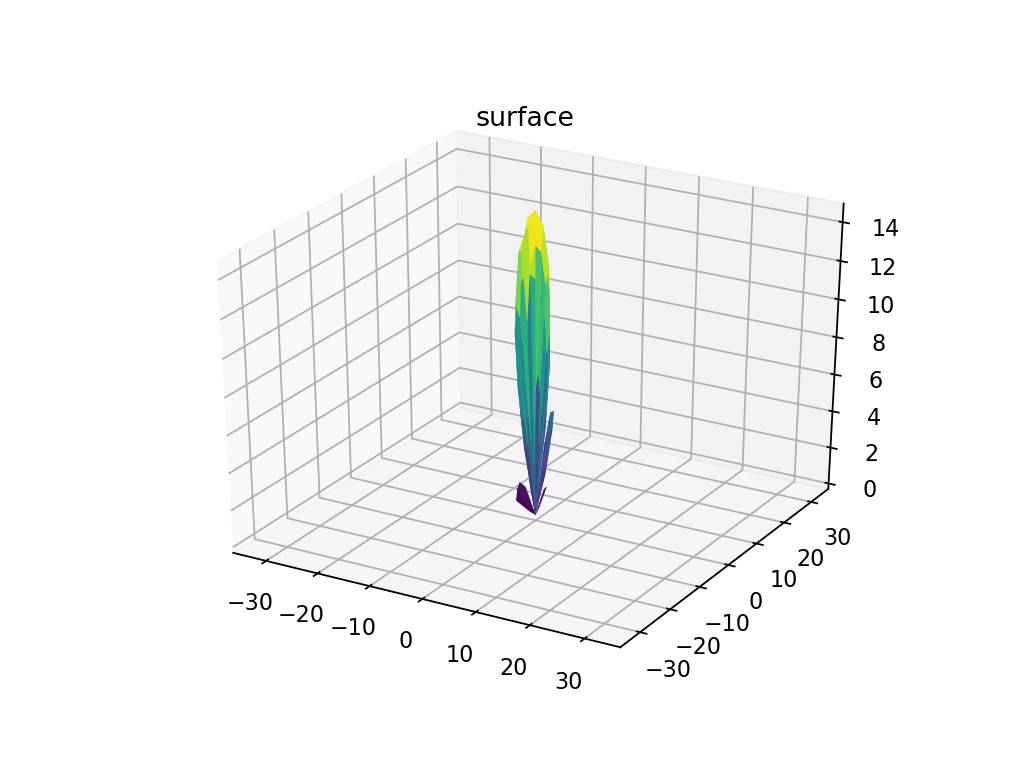

dmax : 18.793389475738312, theta_h : 4.3196898986859615, phi_h : 50.461831998286


In [25]:
theta0 = PI/4
phi0 = PI/3*2
nx = 12
ny = 12
c = wave_length/4
msurf_test = MetaSurfaceArray(nx, ny, c)
msurf_test.get_dir(theta0, phi0)
msurf_test.plot_dir()
theta_h, phi_h = msurf_test.get_hpbw()
dmax = msurf_test.get_maxdir()
print(f'dmax : {dmax}, theta_h : {theta_h}, phi_h : {phi_h}')

In [22]:
nx_rec, ny_rec = find_metasurface([theta0, phi0, dmax, theta_h, phi_h, c])

In [23]:
print(nx_rec)
print(ny_rec)

12
12


### test on metasurface aperture with uniform field

<IPython.core.display.Javascript object>


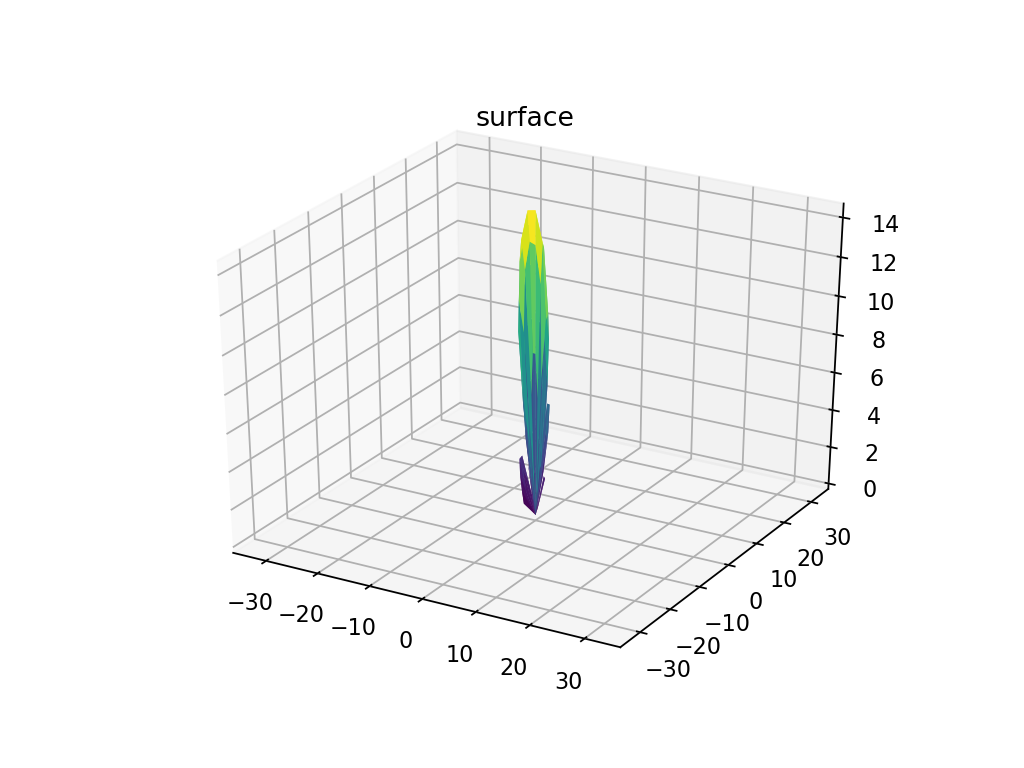

dmax : 20.19, theta_h : 26.51, phi_h : 75.40


In [29]:
theta0 = PI/4
phi0 = PI/3*2
nx = 24
ny = 32
dx = wave_length/8
msurf_test = MetaSurfaceAperture(nx, ny, dx)
msurf_test.set_uniform_e_field(theta0, phi0)
msurf_test.get_dir()
msurf_test.plot_dir()
theta_h, phi_h = msurf_test.get_hpbw()
dmax = msurf_test.get_maxdir()
print(f'dmax : {dmax:.2f}, theta_h : {theta_h:.2f}, phi_h : {phi_h:.2f}')

In [30]:
nx_rec, ny_rec = find_metasurface([theta0, phi0, dmax, theta_h, phi_h, c])
print(nx_rec, ny_rec)
rec_surf = MetaSurfaceArray(nx_rec, ny_rec, c)
rec_surf.get_dir(theta0, phi0)
rec_surf.plot_dir()
print(f'dmax : {dmax:.2f}, theta_h : {theta_h:.2f}, phi_h : {phi_h:.2f}')

16 13
dmax : 20.19, theta_h : 26.51, phi_h : 75.40


### test on metasurface with random amplitude

In [117]:
msurf_test.set_random_e_field(theta0, phi0)
msurf_test.get_dir()
msurf_test.plot_dir()
dmax = msurf_test.get_maxdir()
theta_h, phi_h = msurf_test.get_hpbw()
print(dmax)
print(theta_h, phi_h)

11.956463521462528
146.67310701447332 50.65818153913536


In [116]:
nx_rec, ny_rec = find_metasurface([theta0, phi0, dmax, theta_h, phi_h, c])
print(nx_rec, ny_rec)
rec_surf = MetaSurfaceArray(nx_rec, ny_rec, c)
rec_surf.get_dir(theta0, phi0)
rec_surf.plot_dir()
print(rec_surf.get_maxdir())
print(rec_surf.get_hpbw())

12 3
13.949089133952848
(29.845130209103004, 74.80917506360687)


### conclusion
- random인 경우를 제외하고는 잘 복구해냄